# Development Notebook

#### CCD Implementation

In [ ]:
%load_ext autoreload
%autoreload 2

from fibsem import utils, acquire
from fibsem.structures import BeamType

import numpy as np
import matplotlib.pyplot as plt



microscope, settings = utils.setup_session(ip_address="10.0.0.1", manufacturer="Thermo")


In [ ]:

import napari
viewer = napari.Viewer()



In [ ]:
from pprint import pprint 

microscope.connection.imaging.set_active_view(4)
microscope.connection.imaging.set_active_device(3) #CCD = DEVICE 3, BUT VIEW=4 USUALLY WHAT?

import time
from fibsem.structures import FibsemImage


from napari.qt.threading import thread_worker


@thread_worker
def _acquire_image(microscope):
    i = 0
    images = []
    while True:

        print(f"Acquiring image... {i:04d}")
        image = microscope.connection.imaging.get_image()
        image = FibsemImage(image.data, None)
        # images.append(image)

        yield image
        
        time.sleep(0.2)
        i += 1
        if i > 100:
            break




def _on_yield(image):
    try:
        viewer.layers["data"].data = image.data
    except KeyError:
        viewer.add_image(image.data, name="data")


worker = _acquire_image(microscope)
worker.yielded.connect(_on_yield)
worker.finished.connect(lambda: print("Finished!"))
worker.finished.connect(viewer.close)
worker.start()



In [ ]:

# plot all images

fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
for i, image in enumerate(images):
    axes[i].imshow(image.data, cmap='gray')
    axes[i].set_title(f'Image {i}')
    axes[i].axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

import fibsem.ui.utils as ui_utils
from fibsem.structures import Point
from fibsem.patterning import TrapezoidPattern, _get_milling_stages
import fibsem.utils as utils

In [2]:
microscope, settings = utils.setup_session(ip_address="localhost", manufacturer="Demo")
settings.image.hfw = 40e-6

2023-09-14 16:53:45,383 — root — INFO — connect_to_microscope:4803 — Connected to Demo Microscope
2023-09-14 16:53:45,383 — root — INFO — connect_to_microscope:4804 — Microscope client connected to model Demo with serial number 123456 and software version 0.1
2023-09-14 16:53:45,384 — root — INFO — reset_beam_shifts:4850 — Resetting beam shifts
2023-09-14 16:53:45,385 — root — INFO — setup_session:206 — Finished setup for session: demo_2023-09-14-04-53-45PM


2023-09-14 17:01:34,949 — root — INFO — acquire_image:4818 — Acquiring image: BeamType.ELECTRON


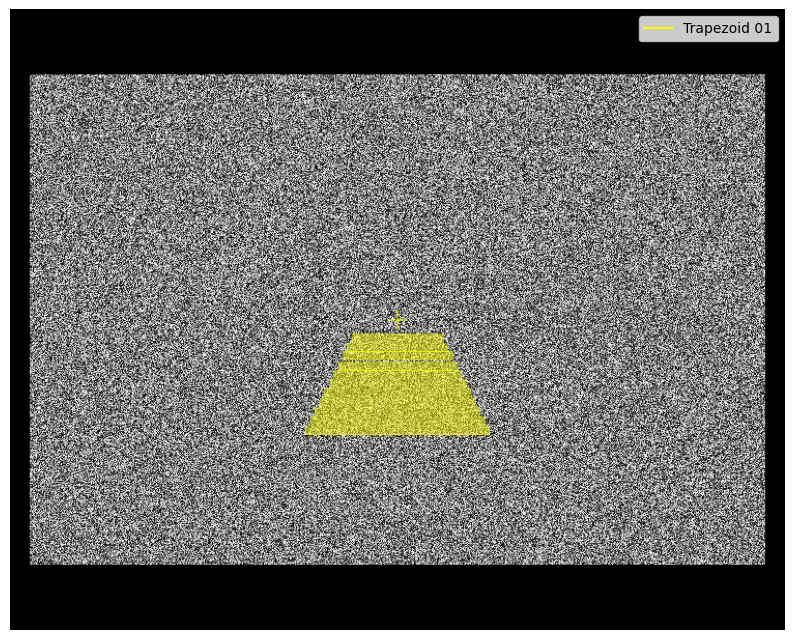

In [11]:
protocol = {
    "Trapezoid": {
    "top_width": 10.0e-6,
    "bottom_width": 20.0e-6,
    "height": 5.0e-6,
    "depth": 1.0e-6,
    "distance": 1.0e-6,
    "n_rectangles": 10,
    "overlap": 0.0,
    "scan_direction": "ToptoBottom",
    "type": "Trapezoid",
    'milling_current': 0.1e-9,
    "hfw": 0.1e-6,
    },
}

img = microscope.acquire_image(settings.image)

stages = _get_milling_stages('Trapezoid', protocol)

fig = ui_utils._draw_milling_stages_on_image(img, stages, show=False)